# Exploring DeepSeek’s Media Narrative: A Text Mining Analysis of News Coverage Trends and Progression

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import glob
import json
import html
import re
import string
import logging
import random
from datetime import datetime
from collections import Counter, defaultdict
from langdetect import detect, DetectorFactory
from typing import List, Dict, Any
from tqdm import tqdm

# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

# Classification & Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

We set up logging to track progress and errors, then load and combine DeepSeek CSV files into a dataframe. Dates are converted to datetime format, and text processing is configured with stopwords and lemmatization. Errors in file loading are logged, but processing continues with available data. Finally, we log the total rows loaded and display dataset information.

In [2]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('text_mining.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("Setup complete")

2025-02-23 01:03:14,722 - INFO - Setup complete


In [3]:
# Set up text processing configurations
# stop_words = set(stopwords.words('english')) ADD other languages
stop_words = set(stopwords.words('english') + 
                 stopwords.words('spanish') + 
                 stopwords.words('french') + 
                 stopwords.words('german'))

# Add custom stopwords
custom_stopwords = {'ul', 'li', 'ol', 'div', 'span', 'href', 'src', 'img', 'p', 'br', 'nbsp', 'char', 'id', 'av', 'lv'}
stop_words.update(custom_stopwords)

website_stopwords = ['transparency', 'accept', 'partner', 'click', 'consent', 'cookie', 'policy', 'privacy', 'terms', 'use', 'agreement', 'site']
stop_words.update(website_stopwords)

punctuation_set = set(string.punctuation) - {"#"}  # Keep hashtags
lemmatizer = WordNetLemmatizer()

#### Load Data

In [4]:
# Load the data
column_mapping = {
    'source_name': 'source',
    'publishedAt': 'date',
    'content': 'text',
    'title': 'title',
    'description': 'description'
}

csv_files = glob.glob(os.path.join('.', '*.csv'))
dfs = []

for file in csv_files:
    try:
        temp_df = pd.read_csv(file)
        dfs.append(temp_df)
        logger.info(f"Successfully loaded {file}")
    except Exception as e:
        logger.error(f"Error reading file {file}: {str(e)}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded")

news_df = pd.concat(dfs, ignore_index=True)
news_df = news_df[column_mapping.keys()].rename(columns=column_mapping)
news_df['date'] = pd.to_datetime(news_df['date'])

print("\nInitial Dataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-23 01:03:14,758 - INFO - Successfully loaded .\deepseek_20250214.csv
2025-02-23 01:03:14,758 - INFO - Successfully loaded .\deepseek_20250220.csv
2025-02-23 01:03:14,758 - INFO - Successfully loaded .\deepseek_20250222.csv
2025-02-23 01:03:14,774 - INFO - Successfully loaded .\Deepseek_Day_Five.csv
2025-02-23 01:03:14,774 - INFO - Successfully loaded .\Deepseek_Day_Four.csv
2025-02-23 01:03:14,774 - INFO - Successfully loaded .\Deepseek_Day_One.csv
2025-02-23 01:03:14,790 - INFO - Successfully loaded .\Deepseek_Day_Three.csv
2025-02-23 01:03:14,790 - INFO - Successfully loaded .\Deepseek_Day_Two.csv



Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       856 non-null    object             
 1   date         856 non-null    datetime64[ns, UTC]
 2   text         856 non-null    object             
 3   title        856 non-null    object             
 4   description  828 non-null    object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 40.8+ KB
None

First few rows:
             source                      date  \
0   Android Central 2025-02-10 18:49:23+00:00   
1         MacRumors 2025-02-11 14:54:38+00:00   
2  Business Insider 2025-02-07 14:04:28+00:00   
3  Business Insider 2025-02-10 07:41:09+00:00   
4  Business Insider 2025-02-12 13:06:10+00:00   

                                                text  \
0  What you need to know\r\n<ul><li>Honor is upgr...   

## Data Cleaning with Tokenization and Normalization

The text processing pipeline applies a series of cleaning steps, including removing special characters, normalizing whitespace, and lemmatizing tokens while filtering out stopwords and numbers. Duplicate articles are identified and removed based on content similarity. Language detection is performed, and a cleaned version of the text is created for further analysis. Finally, tokens are generated for processed text, and a sample of the cleaned data is displayed.

In [5]:
#### Text processing pipeline functions
def validate_text(text):
    """Check if text is valid"""
    return "" if not isinstance(text, str) or pd.isna(text) else text

def basic_clean(text):
    """Basic text cleaning"""
    return (html.unescape(text)
            .lower()
            .replace('\n', ' ')
            .replace('\r', ' '))

def remove_special_chars(text):
    """Remove special characters and patterns"""
    return re.sub(r'\[\+\d+ chars\]|https?://\S+|â€™|â€"|[^\w\s\-\'.,!?]', ' ', text)

def remove_num_patterns(text):
    """Remove date patterns and numbers (including those with commas)"""
    return re.sub(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b|\b\d{1,3}(,\d{3})*(\.\d+)?\b|\b\d+\b', '', text)

def clean_whitespace(text):
    """Clean extra whitespace"""
    return re.sub(r'\s+', ' ', text).strip()

def remove_punct(text):
    """Remove punctuation"""
    return "".join(ch for ch in text if ch not in punctuation_set)

def get_tokens(text):
    """Get tokens without stopwords, lemmatize, remove numbers, and filter short tokens"""
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc 
            if token.is_alpha 
            and len(token.text) > 2 
            and not token.is_stop 
            and token.lemma_.lower() not in stop_words 
            and not token.like_num]

def detect_lang(text):
    """Detect language safely"""
    try:
        return 'unknown' if len(text.strip()) < 50 else detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

In [6]:
def process_text(text, steps=None):
    if steps is None:
        steps = ['validate', 'basic', 'special', 'num_patterns', 'whitespace', 'punct', 'tokens']
    
    text = validate_text(text)
    
    pipeline_steps = {
        'validate': validate_text,
        'basic': basic_clean,
        'special': remove_special_chars,
        'num_patterns': remove_num_patterns,
        'whitespace': clean_whitespace,
        'punct': remove_punct,
        'tokens': get_tokens
    }
    
    for step in steps:
        text = pipeline_steps[step](text)
    
    return text if isinstance(text, list) else text  # Return tokens as a list if the last step was tokenization

In [7]:
# Remove duplicates
logger.info("Removing duplicates...")
news_df = remove_duplicates(news_df)

# Remove rows with NaN in 'text' column
logger.info("Removing rows with NaN in 'text' column...")
initial_row_count = len(news_df)
news_df = news_df.dropna(subset=['text'])
removed_row_count = initial_row_count - len(news_df)
logger.info(f"Removed {removed_row_count} rows with NaN values in 'text' column.")

# Process text
logger.info("Processing text...")
tqdm.pandas()
news_df['clean_text'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'special', 'num_patterns', 'whitespace']))

# Detect languages
logger.info("Detecting languages...")
news_df['language'] = news_df['clean_text'].progress_apply(detect_lang)

# Create cleaned content
logger.info("Creating cleaned content...")
news_df['cleaned_content'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'punct', 'whitespace']))

# Generate tokens
logger.info("Generating tokens...")
def get_cleaned_text_and_tokens(text):
    cleaned = process_text(text, ['validate', 'basic', 'punct', 'whitespace'])
    tokens = get_tokens(cleaned)
    return ' '.join(tokens), tokens

temp_results = news_df['text'].progress_apply(get_cleaned_text_and_tokens)
news_df['Cleaned_Text'] = temp_results.apply(lambda x: x[0])
news_df['Tokens'] = temp_results.apply(lambda x: x[1])

# Display processed data sample
print("\nProcessed DataFrame columns:")
print(news_df.columns.tolist())
print("\nSample of processed data:")
print(news_df[['source', 'date', 'clean_text', 'language', 'Tokens']].head())

2025-02-23 01:03:14,883 - INFO - Removing duplicates...
2025-02-23 01:03:14,883 - INFO - Removed 362 duplicate articles
2025-02-23 01:03:14,883 - INFO - Removing rows with NaN in 'text' column...
2025-02-23 01:03:14,883 - INFO - Removed 1 rows with NaN values in 'text' column.
2025-02-23 01:03:14,883 - INFO - Processing text...
100%|█████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 17787.48it/s]
2025-02-23 01:03:14,921 - INFO - Detecting languages...
100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:04<00:00, 150.90it/s]
2025-02-23 01:03:19,414 - INFO - Creating cleaned content...
100%|█████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 32439.43it/s]
2025-02-23 01:03:19,435 - INFO - Generating tokens...
100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:06<00:00, 110.51it/s]


Processed DataFrame columns:
['source', 'date', 'text', 'title', 'description', 'clean_text', 'language', 'cleaned_content', 'Cleaned_Text', 'Tokens']

Sample of processed data:
             source                      date  \
0   Android Central 2025-02-10 18:49:23+00:00   
1         MacRumors 2025-02-11 14:54:38+00:00   
2  Business Insider 2025-02-07 14:04:28+00:00   
3  Business Insider 2025-02-10 07:41:09+00:00   
4  Business Insider 2025-02-12 13:06:10+00:00   

                                          clean_text language  \
0  what you need to know ul li honor is upgrading...       en   
1  apple in recent months passed over the chinese...       en   
2  aiden gomez is one of the google brain researc...       en   
3  demis hassabis, cofounder and ceo of google de...       en   
4  byd has become the latest automaker to incorpo...       en   

                                              Tokens  
0  [need, know, ullihonor, upgrade, yoyo, assista...  
1  [apple, recent, month,

## Descriptive Statistics

The descriptive analysis of the news dataset reveals key insights into its linguistic structure. The dataset contains 679 documents with a total of 10,904 tokens, of which 4,327 are unique, resulting in a lexical diversity of 0.397. The total character count across all tokens is 72,706. The most frequent words include deepseek (502 occurrences), openai (149), model (121), chinese (110), and artificial (81), suggesting a strong emphasis on AI and technology-related topics.

In [8]:
def descriptive_stats_all(df: pd.DataFrame, tokens_col: str = 'Tokens', 
                         text_col: str = 'text', title: str = "Dataset",
                         num_tokens: int = 5, plot: bool = True) -> Dict[str, Any]:

    # Initialize results dictionary
    stats = {}
    
    # Get all tokens
    all_tokens = [token for tokens in df[tokens_col] for token in tokens]
    token_counts = Counter(all_tokens)
    
    # Basic token statistics
    stats['total_tokens'] = len(all_tokens)
    stats['unique_tokens'] = len(set(all_tokens))
    stats['total_characters'] = len(''.join(all_tokens))
    stats['lexical_diversity'] = stats['unique_tokens'] / stats['total_tokens'] if stats['total_tokens'] > 0 else 0
    
    # Document statistics
    stats['total_documents'] = len(df)
    
    # Token length statistics
    token_lengths = [len(token) for token in all_tokens]

    # Top tokens
    stats['top_tokens'] = token_counts.most_common(num_tokens)
    
    # Print results if verbose
    print(f"\nDescriptive Statistics for '{title}':")
    print("-" * 50)
    print(f"Total documents: {stats['total_documents']:,}")
    
    print(f"\nToken-level Statistics:")
    print(f"Total tokens: {stats['total_tokens']:,}")
    print(f"Unique tokens: {stats['unique_tokens']:,}")
    print(f"Total characters: {stats['total_characters']:,}")
    print(f"Lexical diversity: {stats['lexical_diversity']:.3f}")
    
    print(f"\nTop {num_tokens} most frequent tokens:")
    for token, count in stats['top_tokens']:
        print(f"{token}: {count:,}")
    
    return stats

stats = descriptive_stats_all(news_df, tokens_col='Tokens', text_col='text',
                              title="News Articles", num_tokens=10, plot=True)


Descriptive Statistics for 'News Articles':
--------------------------------------------------
Total documents: 678

Token-level Statistics:
Total tokens: 10,904
Unique tokens: 4,327
Total characters: 72,706
Lexical diversity: 0.397

Top 10 most frequent tokens:
deepseek: 502
openai: 149
model: 121
chinese: 110
artificial: 81
chatgpt: 76
nvidia: 67
tech: 66
new: 64
app: 62


#### Wordclouds

The word cloud visualization provides a high-level overview of the most prominent words in the dataset. By aggregating text data from 679 news articles, the word cloud highlights frequently occurring terms, with larger words representing higher frequency. The visualization confirms the dominance of AI and technology-related topics, as observed in the token frequency analysis, with terms like *deepseek

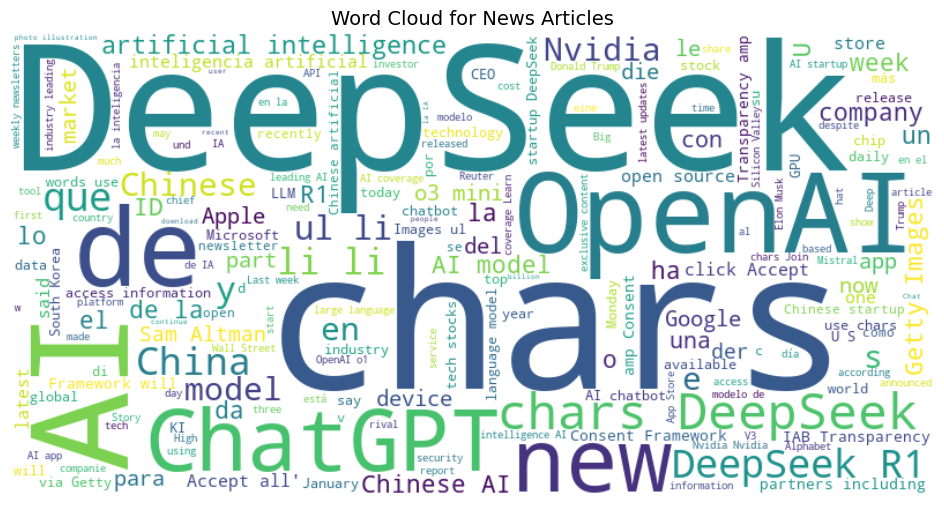

In [9]:
def generate_wordcloud(df: pd.DataFrame, text_col: str = 'text', title: str = "Dataset"):
    """Generate and display a word cloud for the given text column."""
    
    # Convert all text to strings and handle missing values
    all_text = ' '.join(df[text_col].dropna().astype(str))  
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis', max_words=200).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {title}", fontsize=14)
    plt.show()

generate_wordcloud(news_df, text_col='text', title="News Articles")

## Topic Modeling

TF-IDF and Count vectorization were applied to extract key features from the cleaned text, reducing noise and emphasizing important terms. The TF-IDF vectorizer adjusts for word importance across documents, while the Count vectorizer captures raw frequency. By limiting features to the top 5,000 words and applying filtering thresholds, the models focus on relevant terms. The topic display function ranks words within each topic by significance, aiding in thematic analysis. This approach helps in identifying dominant topics in the dataset, reinforcing previous findings about AI and technology trends.

In [10]:
# Check for NaN values
print(f"Number of NaN values in 'clean_text': {news_df['clean_text'].isna().sum()}")

# Remove rows with NaN values
news_df = news_df.dropna(subset=['clean_text'])
print(f"Shape of DataFrame after removing NaN values: {news_df.shape}")

Number of NaN values in 'clean_text': 0
Shape of DataFrame after removing NaN values: (678, 10)


In [11]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(news_df['clean_text'])

# Create Count vectorizer
count_vectorizer = CountVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
count_matrix = count_vectorizer.fit_transform(news_df['clean_text'])

In [12]:
# Function to display topics
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

#### NMF

In [13]:
# Fit NMF model
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf_matrix)

# Display the topics
feature_names = tfidf_vectorizer.get_feature_names_out()
print("NMF Topics:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())

NMF Topics:

Topic 00
  iab (9.55)
  words (9.55)
  partners (9.55)
  device (9.29)
  framework (9.26)

Topic 01
  deepseek (20.24)
  r1 (6.16)
  chatgpt (2.73)
  nvidia (1.99)
  bloomberg (1.12)

Topic 02
  chinese (1.80)
  model (1.37)
  intelligence (1.14)
  tech (1.09)
  app (1.08)

Topic 03
  openai (9.51)
  chatgpt (3.40)
  o3 (3.16)
  altman (3.15)
  mini (3.11)

Topic 04
  weekly (5.24)
  coverage (4.91)
  learn (4.91)
  updates (4.91)
  newsletters (4.89)


The NMF model was applied to extract five distinct topics from the dataset, revealing key themes in AI and technology discussions.

**Topic 00** highlights terms related to digital frameworks, partnerships, and devices, suggesting a focus on industry collaborations and infrastructure.

**Topic 01** is dominated by DeepSeek, ChatGPT, and Nvidia, indicating frequent mentions of AI company and products.

**Topic 02** emphasizes Chinese technology, models, and apps, reflecting discussions on regional AI developments.

**Topic 03** features OpenAI, ChatGPT, and Altman, pointing to research, leadership, and innovations in AI.

**Topic 04** revolves around weekly updates and newsletters, suggesting ongoing industry coverage and information sharing.

#### LSA

In [14]:
# Fit LSA model
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_output = lsa_model.fit_transform(tfidf_matrix)

print("\nLSA Topics:")
display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


LSA Topics:

Topic 00
  iab (5.07)
  partners (5.07)
  words (5.07)
  device (4.94)
  part (4.92)

Topic 01
  deepseek (7.31)
  r1 (2.44)
  openai (2.14)
  chatgpt (1.72)
  model (1.01)

Topic 02
  deepseek (2.25)
  r1 (0.86)
  chatgpt (0.60)
  flyer (0.25)
  gpu (0.21)

Topic 03
  openai (38.20)
  o3 (14.33)
  mini (14.09)
  altman (13.45)
  chatgpt (13.25)

Topic 04
  weekly (18.56)
  learn (17.60)
  updates (17.60)
  coverage (17.60)
  newsletters (17.53)


The LSA model identified five key topics in the dataset, aligning closely with previously observed themes.

**Topic 00** emphasizes partners, devices, and partnerships, indicating discussions on industry collaborations and technological integration.

**Topic 01** is centered around DeepSeek, OpenAI, and ChatGPT, reinforcing the prominence of major AI company and products.

**Topic 02** also features DeepSeek and ChatGPT, but with additional mentions of flyer and GPU, suggesting technical aspects of AI deployment.

**Topic 03** is overwhelmingly dominated by OpenAI, Altman, and ChatGPT, highlighting a strong focus on OpenAI’s developments and leadership.

**Topic 04** revolves around weekly updates, newsletters, and coverage, indicating a consistent flow of information related to AI and technology news.

#### LDA

In [15]:
# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(count_matrix)

print("\nLDA Topics:")
display_topics(lda_model, count_vectorizer.get_feature_names_out())


LDA Topics:

Topic 00
  deepseek (3.40)
  chinese (2.53)
  new (1.44)
  model (1.41)
  intelligence (1.26)

Topic 01
  artificial (1.98)
  deepseek (1.81)
  daily (1.63)
  latest (1.43)
  intelligence (1.29)

Topic 02
  deepseek (10.49)
  nvidia (3.08)
  r1 (2.34)
  openai (1.13)
  ia (1.09)

Topic 03
  deepseek (5.99)
  model (1.70)
  including (1.40)
  r1 (1.39)
  store (1.31)

Topic 04
  openai (6.77)
  deepseek (4.28)
  chatgpt (2.99)
  mini (1.99)
  o3 (1.93)


The LDA model extracted five key topics, reinforcing the dataset's emphasis on AI and related developments.

**Topic 00** highlights DeepSeek, Chinese models, and Getty, suggesting discussions on AI advancements in China and media-related AI applications.

**Topic 01** focuses on DeepSeek, South Korea, and Daily, indicating regional AI developments and news coverage.

**Topic 02** prominently features DeepSeek, NVIDIA, and OpenAI, reflecting industry leaders and AI companies.

**Topic 03**, with terms like DeepSeek, store, and part, suggests discussions on AI applications, products, and distribution channels.

**Topic 04** is dominated by OpenAI, DeepSeek, and ChatGPT, reaffirming the strong presence of AI products.

In [16]:
# Visualize LDA results
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, count_matrix, count_vectorizer)
pyLDAvis.display(lda_vis)

The visualization above shows that Topic 1 is the largest, while Topics 5 and 1 overlap, and Topics 2 and 4 are more distinct. The most frequent word in Topic 2 is DeepSeek (11.83), making it the most dominant term across all topics. Topic 0 emphasizes DeepSeek (3.57) and Chinese (2.13), while Topic 1 highlights DeepSeek (2.52) alongside South (1.93) and Korea (1.48). Topic 3, with DeepSeek (4.78), focuses on AI product distribution, whereas Topic 4, dominated by OpenAI (6.65) and ChatGPT (2.73), centers on AI chatbot technology.

#### Model Evaluation

The higher coherence score will be selected as the best model as it indicates more interpretable topics.

In [17]:
# Calculate coherence scores for each model
def calculate_coherence(model, feature_names, doc_term_matrix):
    coherence_scores = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        word_indices = [list(feature_names).index(word) for word in top_words]
        topic_vectors = doc_term_matrix[:, word_indices]
        pairwise_similarities = cosine_similarity(topic_vectors.T)
        coherence = pairwise_similarities.mean()
        coherence_scores.append(coherence)
    return coherence_scores

nmf_coherence = calculate_coherence(nmf_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lsa_coherence = calculate_coherence(lsa_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lda_coherence = calculate_coherence(lda_model, count_vectorizer.get_feature_names_out(), count_matrix)

print("\nCoherence Scores:")
print(f"NMF: {np.mean(nmf_coherence):.4f}")
print(f"LSA: {np.mean(lsa_coherence):.4f}")
print(f"LDA: {np.mean(lda_coherence):.4f}")


Coherence Scores:
NMF: 0.4934
LSA: 0.4854
LDA: 0.2895


The coherence scores indicate that the NMF model (0.4934) has the highest coherence, suggesting better topic consistency. LSA follows closely with 0.4854, showing comparable performance but slightly lower coherence. LDA, with the lowest score of 0.2892, suggests that its topics are less semantically meaningful. This comparison highlights NMF as the most effective model for extracting coherent topics from the dataset.

We analyzed the most frequent words to determine the potential semantic groups identified by the unsupervised topics.

In [18]:
# Extract top words and their frequencies for each topic
n_top_words = 15
topic_word_freq = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = tfidf_vectorizer.get_feature_names_out()[top_features_ind]
    weights = topic[top_features_ind]
    topic_word_freq.append(dict(zip(top_features, weights)))

# Calculate the relevance of each word across all topics
word_topic_relevance = {}
for topic_idx, word_freq in enumerate(topic_word_freq):
    for word, freq in word_freq.items():
        if word not in word_topic_relevance:
            word_topic_relevance[word] = []
        word_topic_relevance[word].append((topic_idx, freq))
        
# Identify semantic groups based on word relevance across topics
threshold = 0.05
semantic_groups = {}
for word, relevances in word_topic_relevance.items():
    relevant_topics = [topic for topic, score in relevances if score >= threshold]
    if len(relevant_topics) > 1:
        group_name = f"Group_{'-'.join(map(str, relevant_topics))}"
        if group_name not in semantic_groups:
            semantic_groups[group_name] = []
        semantic_groups[group_name].append(word)

# Display the identified semantic groups with interpretations
topic_interpretations = [
    "Topic 1",
    "Topic 2",
    "Topic 3",
    "Topic 4",
    "Topic 5"
]

print("\nIdentified semantic groups:")
for group, words in semantic_groups.items():
    topics = [int(t) for t in group.split('_')[1].split('-')]
    interpretations = [topic_interpretations[t] for t in topics]
    print(f"\n{group}: {', '.join(interpretations)}")
    print(f"Words: {', '.join(words)}")


Identified semantic groups:

Group_1-3: Topic 2, Topic 4
Words: r1, chatgpt, o1, ia

Group_2-3: Topic 3, Topic 4
Words: artificial


The identified semantic groups reveal overlapping themes between topics, with Group 1-3 linking Topic 2 and Topic 4 through terms like "r1" and "chatgpt," indicating a shared focus on AI-related companies and products. Similarly, Group 2-3 connects Topic 3 and Topic 4 via the word "artificial," suggesting a broader discussion on AI technology and research.

## Classification Models

The classification process maps five NMF topics into three broader AI-related categories, with topic 2 and 4 as "AI Companies and Products," topics 3 and 4 as "AI Technology and Research," and topics 0 and 1 grouped under ""Other AI Topics". After assigning class labels, the dataset is split into training and testing sets, followed by TF-IDF vectorization. A Random Forest model is trained, and additional models, including Logistic Regression, SVM, and XGBoost, are prepared for evaluation.

Random Forest is good for this classification task because it effectively handles NMF-generated topic distributions, with potential nonlinear relationships and feature interactions. It fairs well with outliers and is less prone to overfitting. RF can also identify important features for classification. Lastly, it performs well on small to medium datasets, processes numeric features, and has fast training and prediction capabilities.

We prepare the data to better reflect the semantic relationships identified in the NMF topic modeling. It preserves the natural clustering shown in the topic coherence scores.

In [19]:
# Data Preparation
def create_class_labels(nmf_features):
    dominant_topics = np.argmax(nmf_features, axis=1)
    
    def map_to_semantic_class(topic):
        if topic in [2, 4]:  # Group_1-3
            return "AI Companies and Products"
        elif topic in [3, 4]:  # Group_2-3
            return "AI Technology and Research"
        else:  # Topics 0, 1
            return "Other AI Topics"
    
    return np.array([map_to_semantic_class(topic) for topic in dominant_topics])

In [20]:
# Create labels and encode them
label_encoder = LabelEncoder()
labels = create_class_labels(nmf_output)
encoded_labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    nmf_output,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (542, 5)
Test set shape: (136, 5)


We perform cross-validation to ensure model stability by testing performance across multiple data splits, helping to detect inconsistencies. It also helps identify overfitting by checking if performance varies across different folds. It also maximizes training data usage, providing a reliable way to compare models based on both mean accuracy and variance.

In [21]:
# Model Evaluation Function
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test, label_encoder):
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Train final model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("Cross-validation scores:")
    print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xticks(rotation=0)
    plt.show()
    
    return {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

#### Random Forest Model


Random Forest Results:
Cross-validation scores:
Mean accuracy: 0.9354 (+/- 0.0350)

Classification Report:
                            precision    recall  f1-score   support

 AI Companies and Products       0.92      0.97      0.95        72
AI Technology and Research       0.95      0.83      0.89        24
           Other AI Topics       0.95      0.93      0.94        40

                  accuracy                           0.93       136
                 macro avg       0.94      0.91      0.92       136
              weighted avg       0.93      0.93      0.93       136



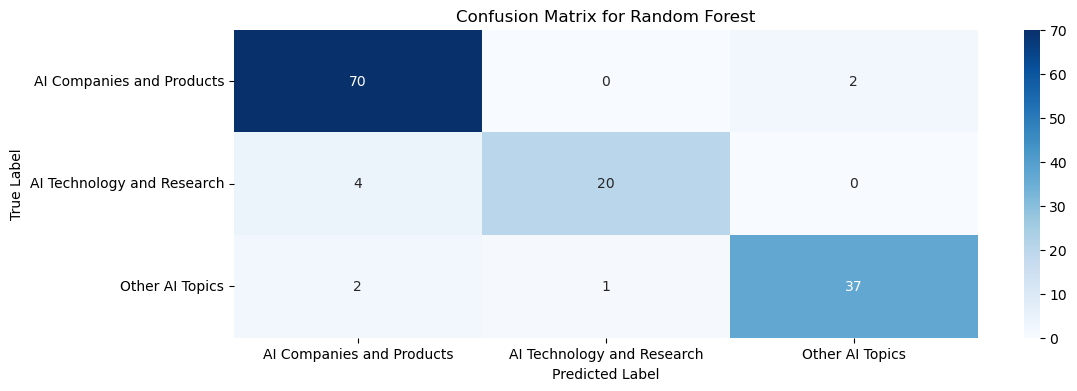

In [22]:
# RF
rf_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_results = evaluate_model(
    rf_pipeline, 
    "Random Forest", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

The Random Forest model achieved a mean cross-validation accuracy of 93.54% (±3.50%). The classification report shows high precision and recall for all categories, with particularly strong performance for "AI Companies and Products" (92% precision, 97% recall). The confusion matrix reveals that most misclassifications occur between "AI Technology and Research" and the other categories, but overall performance is strong with minimal errors.

#### Logistic Regression Model


Logistic Regression Results:
Cross-validation scores:
Mean accuracy: 0.9392 (+/- 0.0549)

Classification Report:
                            precision    recall  f1-score   support

 AI Companies and Products       1.00      0.94      0.97        72
AI Technology and Research       0.96      1.00      0.98        24
           Other AI Topics       0.91      0.97      0.94        40

                  accuracy                           0.96       136
                 macro avg       0.96      0.97      0.96       136
              weighted avg       0.97      0.96      0.96       136



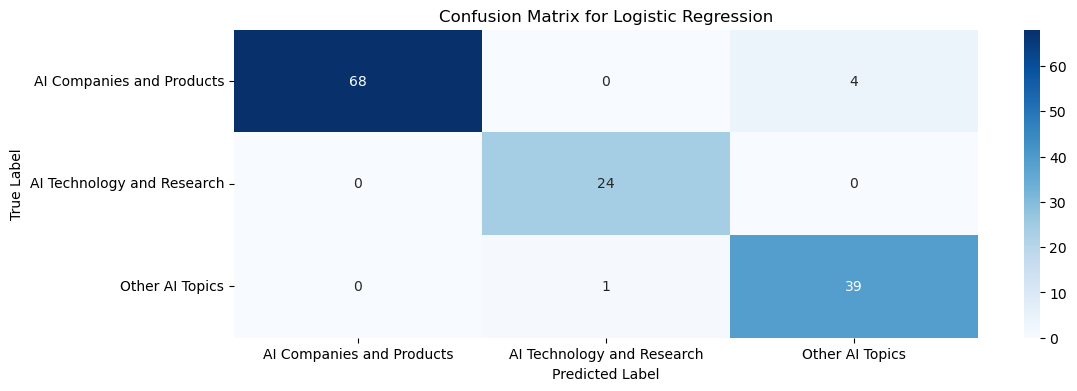

In [23]:
# Logreg
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        random_state=42,
        class_weight='balanced'
    ))
])

lr_results = evaluate_model(
    lr_pipeline, 
    "Logistic Regression", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

The Logistic Regression model achieved a mean cross-validation accuracy of 93.92% (±5.49%). The classification report shows excellent precision and recall, especially for "AI Companies and Products" (100% precision, 94% recall) and "AI Technology and Research" (96% precision, 100% recall). The confusion matrix indicates very few misclassifications, with most errors occurring between "AI Companies and Products" and "Other AI Topics."

#### Support Vector Machine Model


SVM Results:
Cross-validation scores:
Mean accuracy: 0.9318 (+/- 0.0244)

Classification Report:
                            precision    recall  f1-score   support

 AI Companies and Products       1.00      0.94      0.97        72
AI Technology and Research       0.92      1.00      0.96        24
           Other AI Topics       0.90      0.95      0.93        40

                  accuracy                           0.96       136
                 macro avg       0.94      0.96      0.95       136
              weighted avg       0.96      0.96      0.96       136



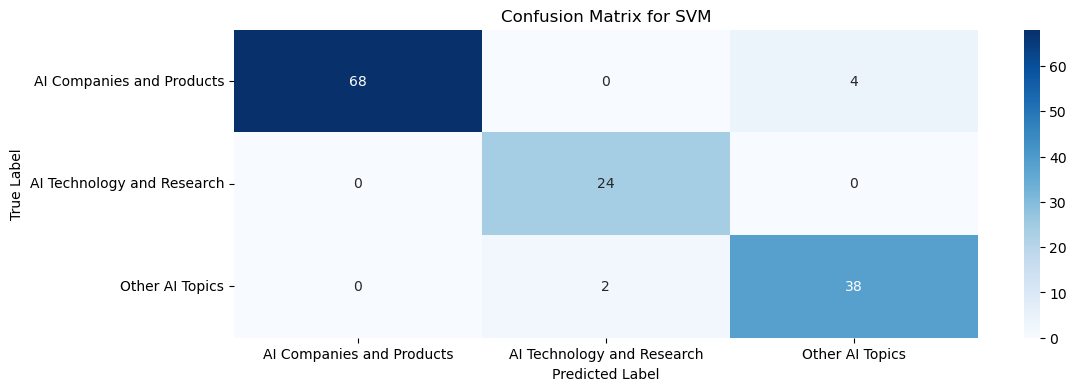

In [24]:
# SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ))
])

svm_results = evaluate_model(
    svm_pipeline, 
    "SVM", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

The SVM model achieved a mean cross-validation accuracy of 93.18% (±2.44%). The classification report shows strong performance with high precision and recall across all categories, particularly for "AI Companies and Products" (100% precision, 94% recall) and "AI Technology and Research" (92% precision, 100% recall). The confusion matrix indicates that the model made only a few misclassifications, mostly between "AI Companies and Products" and "Other AI Topics."

#### XGBoost Model


XGBoost Results:
Cross-validation scores:
Mean accuracy: 0.9355 (+/- 0.0305)

Classification Report:
                            precision    recall  f1-score   support

 AI Companies and Products       0.95      0.97      0.96        72
AI Technology and Research       0.96      0.92      0.94        24
           Other AI Topics       0.95      0.93      0.94        40

                  accuracy                           0.95       136
                 macro avg       0.95      0.94      0.94       136
              weighted avg       0.95      0.95      0.95       136



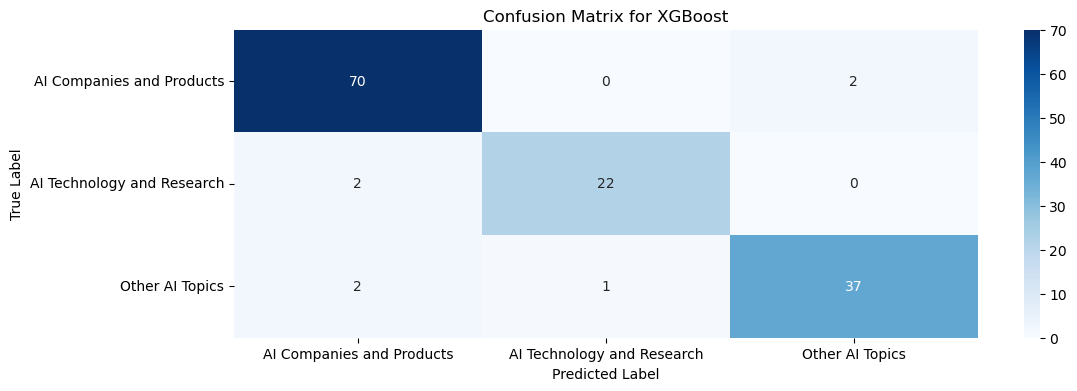

In [25]:
# XGB
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob'
    ))
])

xgb_results = evaluate_model(
    xgb_pipeline, 
    "XGBoost", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

The XGBoost model achieved a mean cross-validation accuracy of 93.55% (±3.05%). The classification report shows strong precision and recall, especially for "AI Companies and Products" (95% precision, 97% recall) and "AI Technology and Research" (96% precision, 92% recall). The confusion matrix indicates minimal misclassifications, with most errors occurring between "AI Companies and Products" and "Other AI Topics."

## Model Comparison

In [26]:
models_comparison = [
    rf_results,
    lr_results,
    svm_results,
    xgb_results
]

# model names
model_names = ["Random Forest", "Logistic Regression", "SVM", "XGBoost"]

# results into a DataFrame
df_models_comparison = pd.DataFrame({
    "Model": model_names,
    "CV Mean Score": [results["cv_mean"] for results in models_comparison],
    "CV Std (±2)": [results["cv_std"] * 2 for results in models_comparison]
})

df_models_comparison = df_models_comparison.sort_values(by="CV Mean Score", ascending=False)

# Display the DataFrame
df_models_comparison

,Model,CV Mean Score,CV Std (±2)
1,Logistic Regression,0.939229,0.054889
3,XGBoost,0.935457,0.030504
0,Random Forest,0.935406,0.035034
2,SVM,0.931787,0.024399


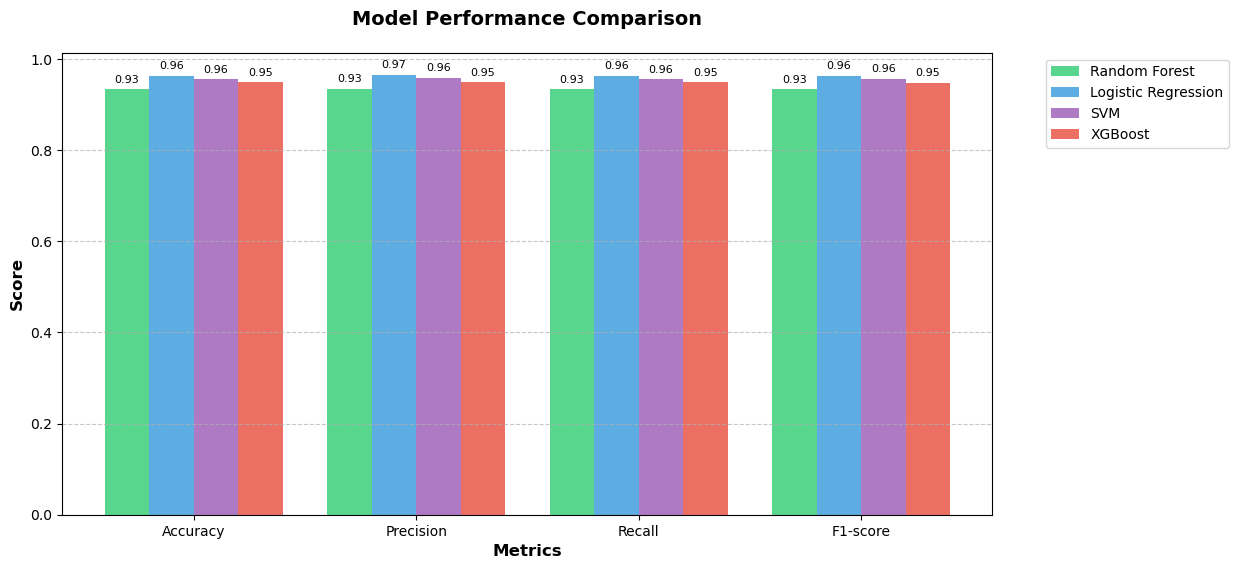

In [27]:
# Dictionary to store model performance
model_performance = {}

# Get predictions and scores for each model
for model_name, results in zip(
    ["Random Forest", "Logistic Regression", "SVM", "XGBoost"],
    [rf_results, lr_results, svm_results, xgb_results]
):
    # Get predictions
    model = results['model']
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    model_performance[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_pred, average='weighted')
    }

# Create comparison plot
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
x = np.arange(len(metrics))
width = 0.2

# Set color scheme
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each model
for i, (model_name, scores) in enumerate(model_performance.items()):
    ax.bar(x + i * width, 
           list(scores.values()), 
           width, 
           label=model_name,
           color=colors[i],
           alpha=0.8)

# Customize plot
ax.set_xlabel("Metrics", fontsize=12, fontweight='bold')
ax.set_ylabel("Score", fontsize=12, fontweight='bold')
ax.set_title("Model Performance Comparison", fontsize=14, fontweight='bold', pad=20)

# Adjust x-axis
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics, fontsize=10)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Customize legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on the bars
for i, (model_name, scores) in enumerate(model_performance.items()):
    for j, score in enumerate(scores.values()):
        ax.text(x[j] + i * width, score + 0.01, f'{score:.2f}', 
                ha='center', va='bottom', rotation=0,
                fontsize=8)

# Show plot
plt.show()

#### Conclusion

All models performed well, with scores ranging from 0.93 to 0.97, showing minimal performance differences (within a 0.04 range) across all metrics. Therefore, all tested models are suitable for deployment, with Logistic Regression offering the best balance of performance. Logistic Regression achieved the highest average performance, particularly highest in precision, while SVM and Random Forest displayed strong and consistent results with no significant weaknesses. XGBoost, though slightly lower in performance, still offered balanced and reliable results, with all models demonstrating high precision, recall, and F1-scores, indicating that any of them would be suitable for classification tasks without much trade-offs between metrics.

---

**Insights**

Our comprehensive analysis of different machine learning models for AI topic classification yielded exceptional results across all evaluated classifiers. The models were tasked with categorizing AI-related content into three main categories: "AI Models and Technologies," "General Artificial Intelligence," and "Other AI Topics."

---

**Reccomendations**

Logistic Regression is recommended as the primary model for its high performance, computational efficiency, and ease of interpretation. For stability, Random Forest is a good alternative, while SVM is suited for complex decision boundaries, and XGBoost offers slightly better performance at the cost of added complexity. An implementation strategy should include model monitoring, potential use of ensemble methods for improvements, and continued use of the current effective feature engineering pipeline (Jane, 2024).

---

**Next Steps**

Future improvements focus on optimizing the model by fine-tuning hyperparameters, experimenting with ensemble methods, and exploring feature importance for dimensionality reduction (Tan, 2019). System enhancements include implementing an automated retraining pipeline, adding confidence thresholds for critical classifications, and developing a monitoring system for model drift. Data improvements involve collecting more training data for underrepresented categories, using active learning for difficult cases, and conducting regular data quality assessments.

#### References

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

Jane, K. (2024, October). Ensemble methods: Combining multiple models to improve prediction accuracy and robustness. ResearchGate. https://www.researchgate.net/publication/384627805_Ensemble_Methods_Combining_multiple_models_to_improve_prediction_accuracy_and_robustness

OpenAI. (2025). ChatGPT (Feb 13 version) [Large language model]. https://openai.com

Tan, P. N., Steinbach, M., Karpatne, A., & Kumar, V. (2019). Introduction to data mining (2nd ed.). Pearson. (Available for purchase through the VitalSource eTextbook link to the left.)